# Stroke prediction 

- Cílem práce je binární klasifikace mrtvice. 
- V práci byly použity algoritmy strojového učení - náhodný les a logistická regrese. 
- Autoři práce: Kryštof Dostál, Artem Sorokin


## O datasetu:
### Kontext

Podle Světové zdravotnické organizace (WHO) je cévní mozková příhoda celosvětově druhou nejčastější příčinou úmrtí a je zodpovědná za přibližně 11 % všech úmrtí. 
Tento soubor dat slouží k předpovědi, zda pacient pravděpodobně dostane mrtvici, na základě vstupních parametrů, jako je pohlaví, věk, různá onemocnění a kuřácký status. Každý řádek v datech poskytuje relevantní informace o pacientovi.

### Informace o atributu

1) id: unikátní identifikátor

2) gender: "Muž", "Žena" nebo "Jiné"

3) age: věk pacienta

4) hypertension: 0 pokud pacient nemá hypertenzi, 1 pokud pacient hypertenzi má

5) heart_disease: pokud pacient nemá žádné srdeční onemocnění 0, pokud pacient má srdeční onemocnění 1

6) ever_married (někdy_ženatý): "Ne" nebo "Ano"

7) work_type (typ práce): "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "venkovský" nebo "městský"

9) avg_glucose_level: průměrná hladina glukózy v krvi

10) bmi: index tělesné hmotnosti

11) smoking_status (stav kouření): "dříve kouřil", "nikdy nekouřil", "kouří" nebo "neznámý ".

12) stroke: 1 pokud pacient prodělal mrtvici, nebo 0 pokud ne **(cílová proměnná)**

viz. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Import potřebných knihoven. Jedná se hlavně o knihovnu *scikit-learn*, která poskytuje metody a třídy pro rozdělení, a vyhodnocování datasetů a potřebné ML modely pro predikce nad těmito datasety, viz. https://scikit-learn.org/stable/modules/classes.html

Dále používáme knihovnu *imbalanced-learn* pro vyvážení poměru predikované proměnné v datasetu viz. https://imbalanced-learn.org/stable/user_guide.html

Také knihovnu *pyplot* pro vykreslování grafů a itertools pro funkcionalitu při vybírání hyperparametrů.

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours 


%matplotlib inline

In [33]:
np.random.seed(42)

In [34]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv", sep = ',', index_col = 'id')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Průzkumná analýza dat

In [35]:
# absolutní hodnoty cílové proměnné 
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [36]:
# relativní hodnoty cílové proměnné 

stroke_0 = len(data[data['stroke'] == 0])
stroke_1 = len(data[data['stroke'] == 1])
procento_stroke_0 = stroke_0 / (stroke_0 + stroke_1)
procento_stroke_1 = stroke_1 / (stroke_0 + stroke_1)
print(f'Procento pacientů s inzultem: {round(procento_stroke_1, 3)}\nProcento pacientů bez inzultu: {round(procento_stroke_0, 3)}')

Procento pacientů s inzultem: 0.049
Procento pacientů bez inzultu: 0.951


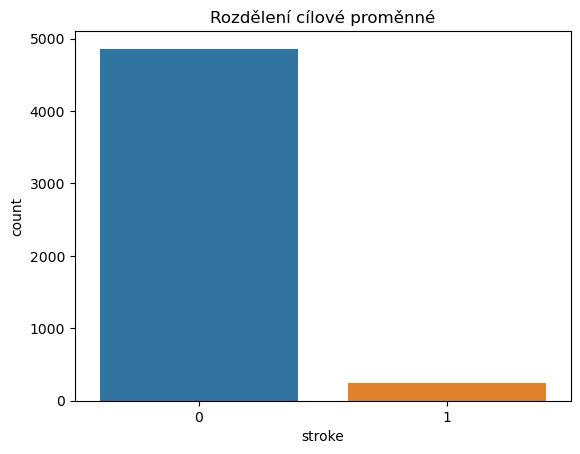

In [37]:
x = [0,1]
y = [data['stroke'].value_counts()[0], data['stroke'].value_counts()[1]]
sns.barplot(x = x, y = y)
plt.xlabel('stroke')
plt.ylabel('count')
plt.title('Rozdělení cílové proměnné')
#plt.savefig('Rozdělení cílové proměnné.png', dpi = 100)
plt.show()

In [38]:
# Informace o kvantitativních proměnných seskupené na základě cílové proměnné

data.groupby('stroke').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,41.971545,0.088871,0.047110,104.795513,28.823064
1,67.728193,0.265060,0.188755,132.544739,30.471292


- Průměrný věk s mrtvicí je o 26 let vyšší než bez ní.
- 26 % pacientů s mrtvicí mělo hypertenzi 
- 8 % sledovaných osob ve skupině bez mrtvice mělo hypertenzi. 
- 19 % pacientů s mrtvicí mělo srdeční onemocnění 
- 4 % ze skupiny bez mrtvice trpěla srdečním onemocněním. 
- Průměrná hladina glukózy u pacientů s cévní mozkovou příhodou = 132,5
- Průměrná hladina glukózy u pacientů bez mrtvice = 104,8
- Průměrný index tělesné hmotnosti pacientů s cévní mozkovou příhodou 30,5
- Průměrný BMI pacientů bez mrtvice = 28,8

In [39]:
# Rozdělení datasetu pro podrobné srovnání obou cílových skupin 

data_0 = data[data['stroke'] == 0]
data_1 = data[data['stroke'] == 1]

### Age

In [40]:
data['age'].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

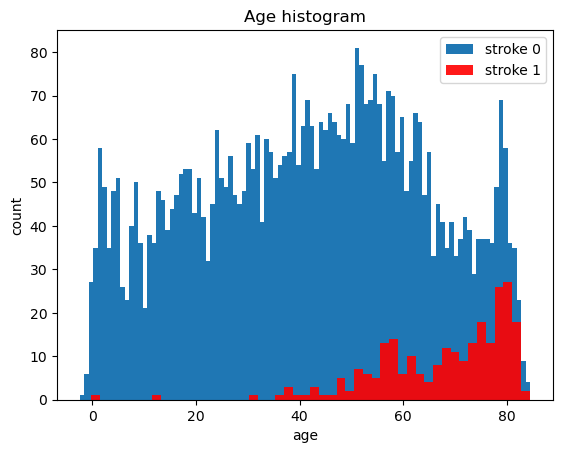

In [41]:
# Přidání šumu do proměnné "age"

age_0 = data_0['age']
noise = np.random.normal(0, 1.0, size=len(data_0))
age0_jitter = age_0 + noise
age_1 = data_1['age']
noise = np.random.normal(0, 1.0, size=len(data_1))
age1_jitter = age_1 + noise


plt.hist(age0_jitter, bins = 100,  alpha = 1, label='stroke 0')
plt.hist(age1_jitter, bins = 50, alpha = 0.9, label='stroke 1', color = 'red')
plt.xlabel('age')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('Age histogram')
#plt.savefig('Age histogram.png', dpi = 100)
plt.show()

- Z histogramu je patrné, že většina lidí, kteří prodělali mrtvici, byla ve věku 40-42 let.
- A můžete také vidět, že několik pacientů s mrtvicí je v poměrně mladém věku.

### avg_glucose_level

In [42]:
data['avg_glucose_level'].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

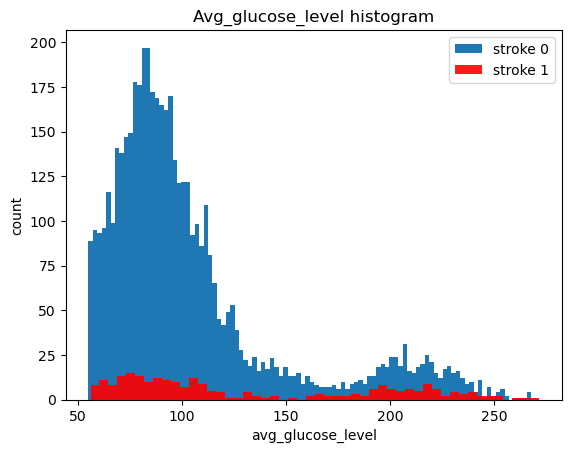

In [43]:
plt.hist(data_0['avg_glucose_level'], bins = 100,  alpha = 1, label='stroke 0')
plt.hist(data_1['avg_glucose_level'], bins = 50, alpha = 0.9, label='stroke 1', color = 'red')
plt.xlabel('avg_glucose_level')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('Avg_glucose_level histogram')
plt.show()

- Z tohoto histogramu je patrné, že rozložení průměrných hladin glukózy v obou skupinách je velmi podobné

### BMI

In [44]:
data['bmi'].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

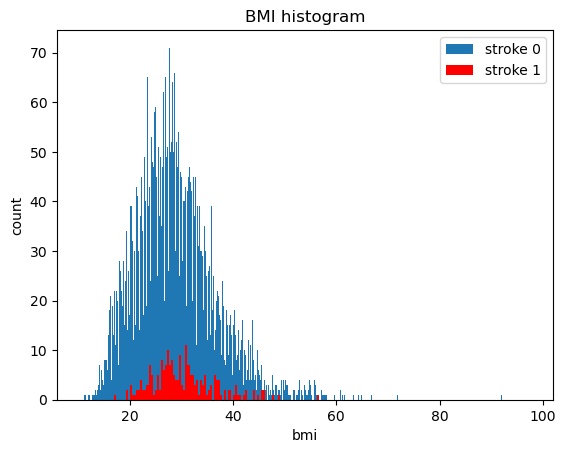

In [45]:
plt.hist(data_0['bmi'], bins = 500,  alpha = 1, label='stroke 0')
plt.hist(data_1['bmi'], bins = 100, alpha = 1, label='stroke 1', color = 'red')
plt.xlabel('bmi')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('BMI histogram')
plt.show()

- Rozdělení atributu BMI se také příliš neliší 

#### Boxploty pro BMI

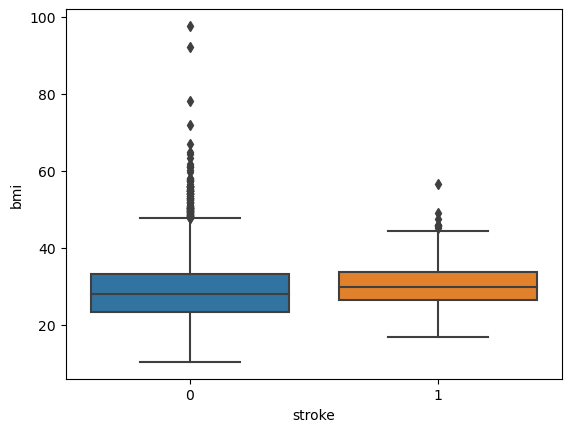

In [46]:
sns.boxplot(x='stroke', y='bmi', data=data)
plt.show()

Dolní kvartil skupiny s cévní mozkovou příhodou (1) je o něco vyšší než u skupiny bez cévní mozkové příhody (0). To dává smysl, protože většina pacientů s mrtvicí byla v dospělosti. 

In [47]:
# Bližší pohled na pacienty s extrémně vysokým BMI 

bmi_nad_60 = data['bmi'] > 70
data.loc[bmi_nad_60]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


----

## Analýza kategoriálních proměnných 

### Gender

In [48]:
data.groupby('gender').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
gender,,,,,,
Female,43.757395,0.092184,0.037742,104.057809,29.065758,0.047094
Male,42.483385,0.104965,0.077069,109.088520,28.647936,0.051064
Other,26.000000,0.000000,0.000000,143.330000,22.400000,0.000000


- Ženy mají nižší výskyt cévních srdečních onemocnění než muži.
- Ženy mají o něco nižší hladinu glukózy. 
- A ženy mají o 0,3 % méně mrtvic než muži.

### Ever_married

In [49]:
data.groupby('ever_married').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
ever_married,,,,,,
No,22.014229,0.030165,0.018213,96.44815,25.214721,0.016505
Yes,54.342082,0.132717,0.072771,111.23031,30.850749,0.065613


- Průměrný věk skupiny "No" je mnohem nižší než věk skupiny "Yes".
- A proto jsou všechny ukazatele lepší než ve skupině "Yes".

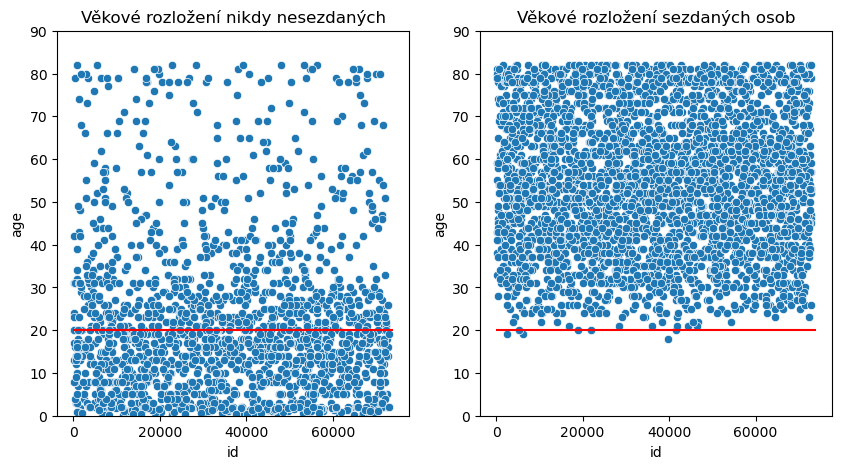

In [50]:
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
sns.scatterplot(data = data[data['ever_married'] == 'No'], x="id", y="age")
plt.ylim([0, 90])
plt.title('Věkové rozložení nikdy nesezdaných')
plt.hlines(20, -100, 74000, color = 'r')

plt.subplot(1, 2, 2)
sns.scatterplot(data = data[data['ever_married'] == 'Yes'], x="id", y="age")
plt.ylim([0, 90])
plt.title('Věkové rozložení sezdaných osob')
plt.hlines(20, -100, 74000, color = 'r')

plt.show()

- Lidé se samozřejmě berou ve vyšším věku. Proto se tyto dvě skupiny velmi liší 

#### Filtrace. Věk pacientů nad 40 let

In [51]:
data_nad_40 = data[data['age'] > 40]
data_nad_40.groupby('ever_married').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
ever_married,,,,,,
No,59.644628,0.169421,0.128099,107.764876,30.802183,0.107438
Yes,60.225229,0.158155,0.092226,114.963773,30.872676,0.081936


- Zde jsou věkové skupiny +- vyrovnané a rozdíl je již patrný v počtu mrtvic. 

### Work_type

In [52]:
data.groupby('work_type').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
work_type,,,,,,
Govt_job,50.879756,0.111111,0.054795,107.779772,30.522063,0.050228
Never_worked,16.181818,0.000000,0.000000,96.042727,25.545455,0.000000
Private,45.503932,0.096068,0.054017,106.796844,30.304625,0.050940
Self-employed,60.201465,0.175824,0.098901,112.645446,30.211871,0.079365
children,6.841339,0.000000,0.001456,94.400277,20.038003,0.002911


- **Práce ve státní správě** a **Privat** jsou si ve všech oblastech velmi podobné 
- **Samostatně výdělečně činní** mají vysoký průměrný věk, a proto jsou všechny ostatní ukazatele horší.
- **Never_worked** a **children** jsou si také velmi podobné

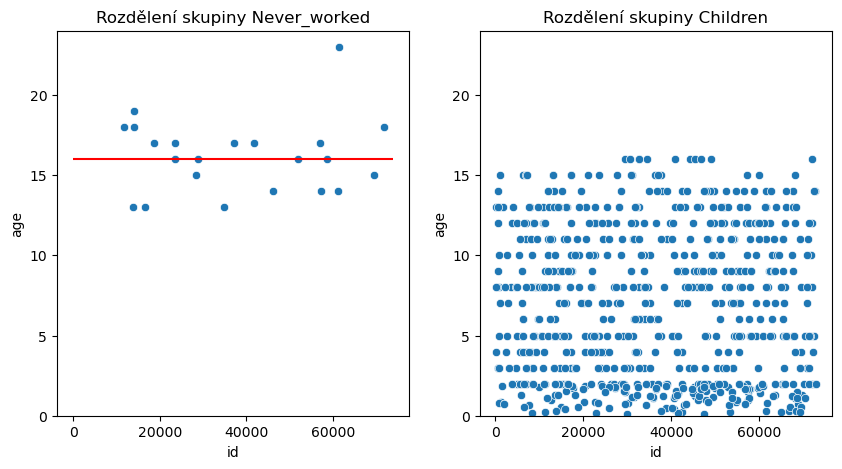

In [53]:
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
sns.scatterplot(data = data[data['work_type'] == 'Never_worked'], x="id", y="age")
plt.ylim([0, 24])
plt.hlines(16, -100, 74000, color = 'r')
plt.title('Rozdělení skupiny Never_worked')

plt.subplot(1, 2, 2)
sns.scatterplot(data = data[data['work_type'] == 'children'], x="id", y="age")
plt.ylim([0, 24])
plt.title('Rozdělení skupiny Children')

plt.show()

Z grafu je patrné, že skupina Never_worked zahrnuje i osoby mladší 16 let. 
V dalším kroku změníme jejich příslušnost ke skupině

In [54]:
# vytvořte dataframe s pouze Never_worked mladšími 16 let a změňte jejich status na děti.

never_workd = data['work_type'] == 'Never_worked'
age_do_16 = data['age'] <= 16
data_test = data.loc[never_workd & age_do_16]
data_test = data_test.replace('Never_worked', 'children') 

In [55]:
# vytvořte dadaframe data_drop a odstraňte z něj pozorování, která byla změněna 

data_drop = data
data_drop = data_drop.drop(data_test.index, axis = 0) # производим drop 

# Merge
data = pd.concat([data_drop, data_test])

In [56]:
# dvě děti s mrtvicí
children = data['work_type'] == 'children'
stroke1 = data['stroke'] == 1
data.loc[children & stroke1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


### Residence_type

In [57]:
data.groupby('Residence_type').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
Residence_type,,,,,,
Rural,42.900811,0.099841,0.053302,106.375235,28.894212,0.045346
Urban,43.542126,0.095146,0.054700,105.927307,28.892289,0.052003


Podle všech měřítek jsou obě skupiny téměř nerozlišitelné. Je tu však velký **rozdíl v mrtvicích**.

Čerstvý vzduch má zřejmě velký vliv. 

### Smoking_status

In [58]:
data.groupby('smoking_status').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
smoking_status,,,,,,
Unknown,30.229922,0.033679,0.031088,99.601541,25.666352,0.030440
formerly smoked,54.929944,0.135593,0.087006,112.886079,30.747192,0.079096
never smoked,46.744715,0.122622,0.047569,107.558092,29.982559,0.047569
smokes,47.096324,0.119138,0.077313,108.017440,30.543555,0.053232


- Zdá se, že skupina **Unknown** zahrnuje všechny děti a mladé lidi (musíme se podívat na věkovou tabulku).
- **formerly smoked** mají vysoký průměrný věk a v důsledku toho jsou hodnoty horší. 
- **smokes** a **never smoked** jsou si velmi podobní ve všech ohledech kromě srdečních onemocnění a mrtvice.

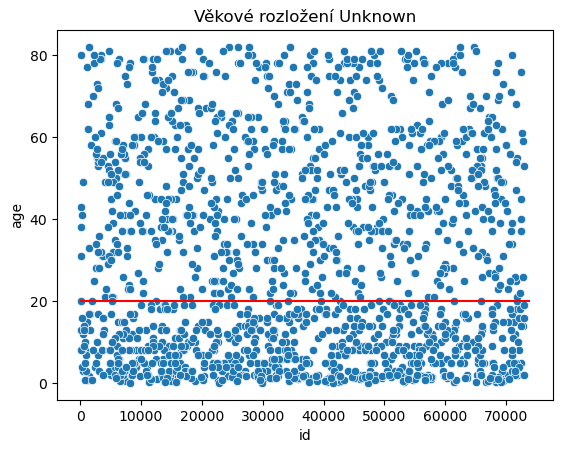

In [59]:
# graf ukazuje, že většina Unknown je mladší 20 let.
sns.scatterplot(data = data[data['smoking_status'] == 'Unknown'], x="id", y="age")
plt.title('Věkové rozložení Unknown')
plt.hlines(20, -100, 74000, color = 'r')

plt.show()

In [60]:
# Unknown a mrtvice
Unknown = data['smoking_status'] == 'Unknown'
stroke1 = data['stroke'] == 1
data.loc[Unknown & stroke1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
27419,Female,59.00,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
60491,Female,78.00,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8213,Male,78.00,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
25226,Male,57.00,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
64778,Male,82.00,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1
61843,Male,58.00,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
33879,Male,42.00,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
47306,Male,58.00,0,0,No,Private,Rural,92.62,32.0,Unknown,1
37937,Female,75.00,0,1,No,Self-employed,Urban,109.78,NaN,Unknown,1


## Předzpracování dat

In [61]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### BMI

In [62]:
# zpracování chybějících hodnot v BMI
data = data.fillna({'bmi': data['bmi'].mean()})

### Gender

In [63]:
# odstranění pozorování bez pohlaví (Je zde pouze jedno pozorování)
data = data[data['gender'] != 'Other']

### Binarni promenne

In [64]:
# vytvoření slovníku pro rekódování proměnných se dvěma hodnotami 

binominal_objects = {
    'gender': {'Female': 0, 'Male': 1},
    'ever_married': {'No': 0, 'Yes': 1},
    'Residence_type': {'Urban': 0, 'Rural': 1}
}

# prekodovani
data = data.replace(binominal_objects)

Binární proměnné ponecháváme zakódvané jako 0/1 místo dummy příznaků, to kvůli redukci dimenzionality. viz. https://stackoverflow.com/questions/61528588/can-sklearn-random-forest-classifier-handle-categorical-variables a https://stackoverflow.com/questions/65722374/one-hot-encoding-in-random-forest-classifier

### Dummies work_type

In [65]:
# One_Hot_Encoding Work_type
data = pd.get_dummies(data, columns = ['work_type'], prefix = ['work_type'])
data.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
id,,,,,,,,,,,,,,,
9046,1,67.0,0,1,1,0,228.69,36.600000,formerly smoked,1,0,0,1,0,0
51676,0,61.0,0,0,1,1,202.21,28.893237,never smoked,1,0,0,0,1,0
31112,1,80.0,0,1,1,1,105.92,32.500000,never smoked,1,0,0,1,0,0
60182,0,49.0,0,0,1,0,171.23,34.400000,smokes,1,0,0,1,0,0
1665,0,79.0,1,0,1,1,174.12,24.000000,never smoked,1,0,0,0,1,0


### Smouking_status (eliminace chybějících hodnot)

In [66]:
# Převod do číselného formátu 

factor = pd.factorize(data['smoking_status'])
data.smoking_status = factor[0]
definitions = factor[1]
print(data.smoking_status.head())
print(definitions)

id
9046     0
51676    1
31112    1
60182    2
1665     1
Name: smoking_status, dtype: int64
Index(['formerly smoked', 'never smoked', 'smokes', 'Unknown'], dtype='object')


In [67]:
# Kontrola změny datového typu 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 9046 to 58652
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   5109 non-null   int64  
 1   age                      5109 non-null   float64
 2   hypertension             5109 non-null   int64  
 3   heart_disease            5109 non-null   int64  
 4   ever_married             5109 non-null   int64  
 5   Residence_type           5109 non-null   int64  
 6   avg_glucose_level        5109 non-null   float64
 7   bmi                      5109 non-null   float64
 8   smoking_status           5109 non-null   int64  
 9   stroke                   5109 non-null   int64  
 10  work_type_Govt_job       5109 non-null   uint8  
 11  work_type_Never_worked   5109 non-null   uint8  
 12  work_type_Private        5109 non-null   uint8  
 13  work_type_Self-employed  5109 non-null   uint8  
 14  work_type_children  

In [68]:
# rozdelovani datasetu na Unknown a ostatni 
data_to_predict_smoking_status = data[data['smoking_status'] == 3]
data_to_train_smoking_status = data[data['smoking_status'] != 3]

In [69]:
# Výpis názvů sloupců 
data_to_train_smoking_status.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children'],
      dtype='object')

In [70]:
# spliting
predictors = ['gender', 'age', 'hypertension', 'heart_disease',
              'ever_married','Residence_type', 'avg_glucose_level',
              'bmi', 'work_type_Govt_job', 'work_type_Never_worked',
              'work_type_Private', 'work_type_Self-employed', 'work_type_children']
X_train = data_to_train_smoking_status[predictors].values
y_train = data_to_train_smoking_status['smoking_status'].values
X_predict = data_to_predict_smoking_status[predictors].values

In [71]:
# Normalizace velikosti proměnných
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)

In [72]:
# RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

print(f'Accuracy on training data: {classifier.score(X_train, y_train)}')

Accuracy on training data: 0.9803646563814866


In [73]:
# predicovane hodnoty
y_predicted = classifier.predict(X_predict)

In [74]:
# Nahrazení hodnot "unknown" předpokládanými hodnotami
data_to_predict_smoking_status = data_to_predict_smoking_status.drop(columns = ['smoking_status'],axis = 1)
data_to_predict_smoking_status['smoking_status'] = y_predicted

In [75]:
# Opětovné propojení datových sad
data = pd.concat([data_to_predict_smoking_status, data_to_train_smoking_status])

In [76]:
# Změna číselného ukazatele na slovní. Pro přehlednost 
data = data.replace({'smoking_status': {0: 'formerly smoked', 1: 'never smoked', 2: 'smokes'}})

### Dummies smoking_status

In [77]:
# One_Hot_Encoding smoking_status
data = pd.get_dummies(data, columns = ['smoking_status'], prefix=['smoking_status'])

### Korelace

In [79]:
# Tvorba korelační matice
corr_matrix = np.triu(data.loc[:,].corr())

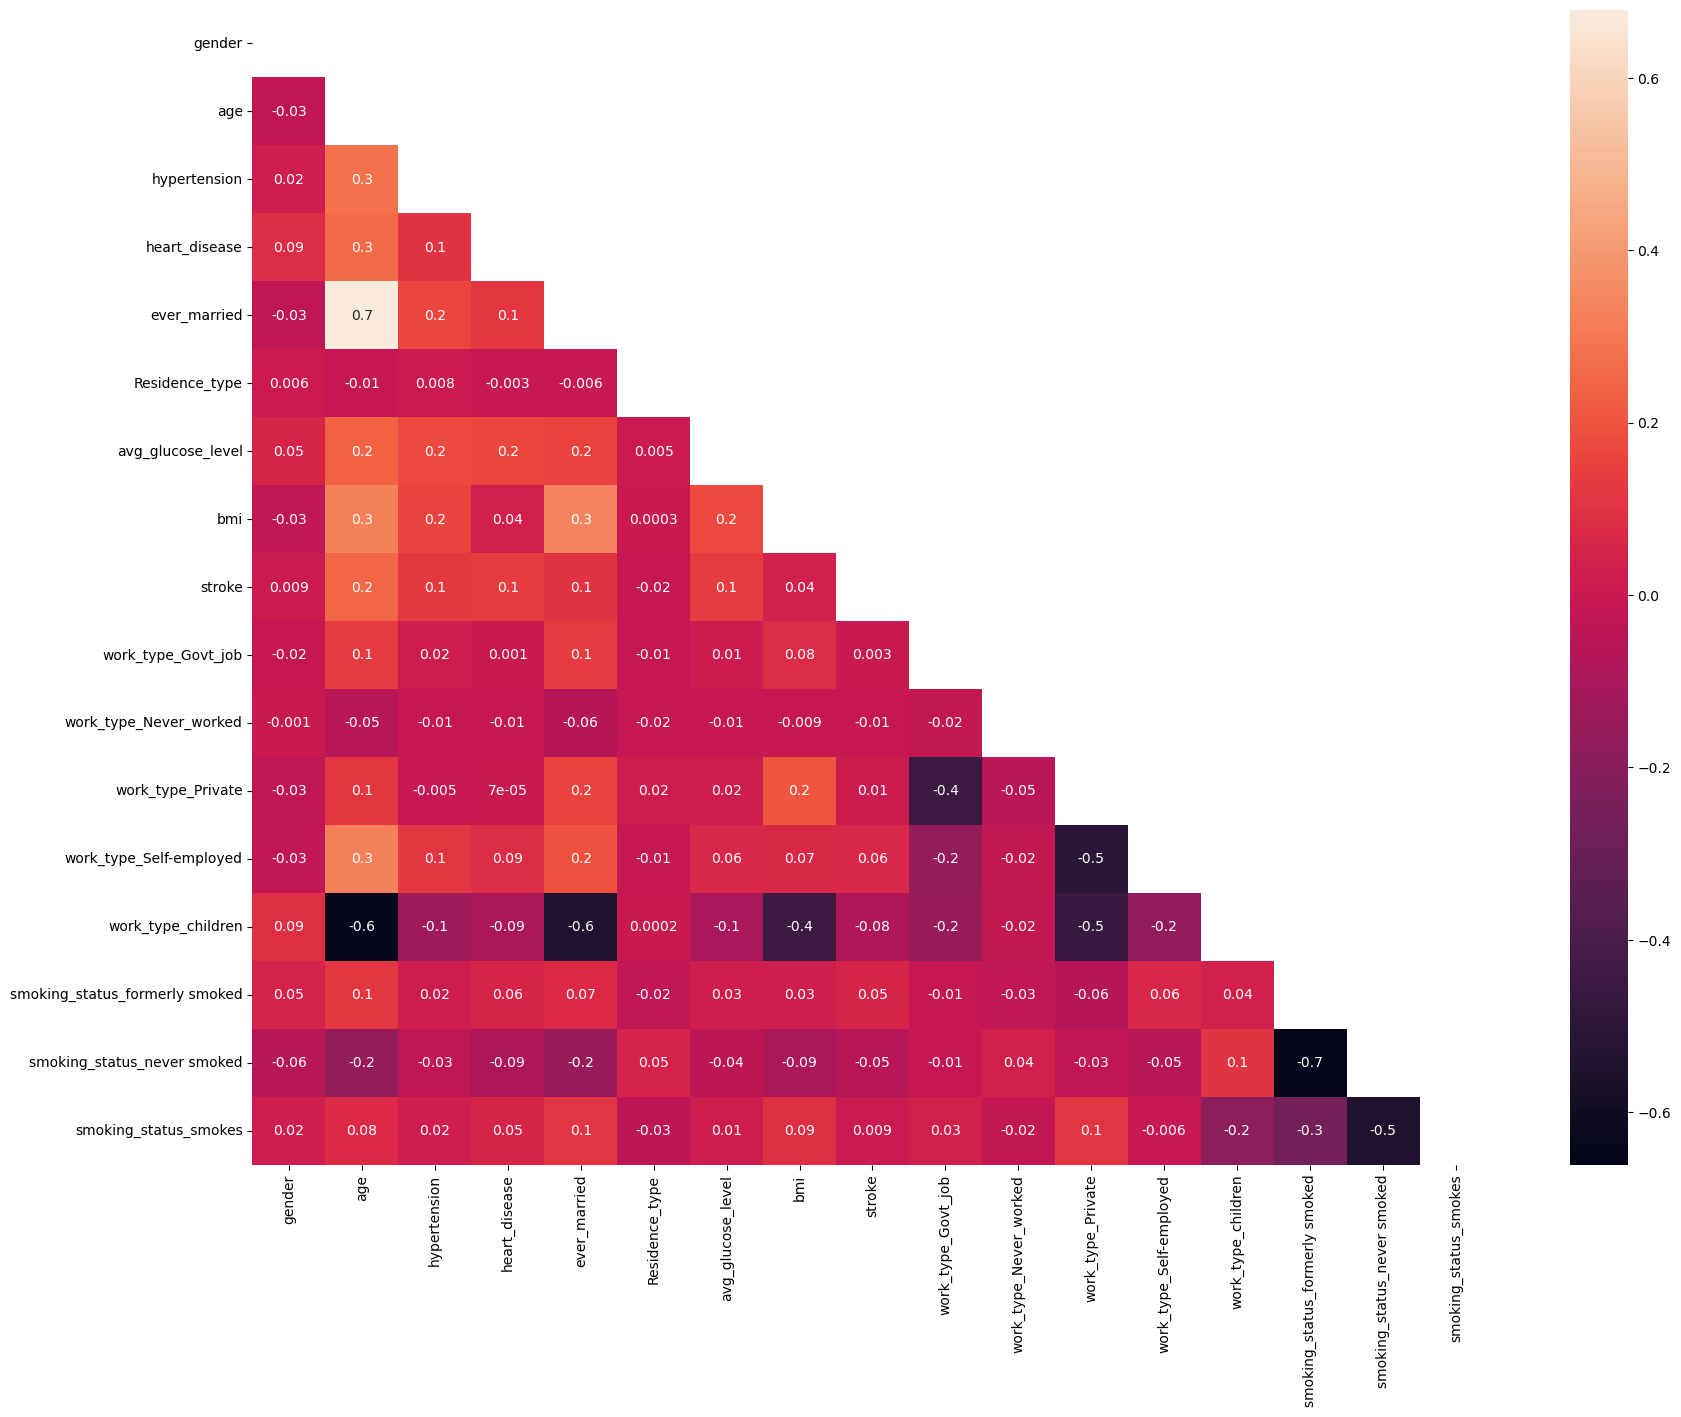

In [80]:
# Použití heatmap k vizualizaci korelační matice
plt.figure(figsize = (20,15))
sns.heatmap(data.loc[:,].corr(), annot=True, fmt = '.1g', mask = corr_matrix )
plt.savefig('Korelační matice.png', dpi = 100)
plt.show()

Na základě výsledků korelační matice a provedených testů byla odstraněna proměnná **Ever_married**.
Rozhodnutí o jejím odstranění bylo učiněno na základě silného lineárního vztahu s proměnnou Age.

Byly také učiněny pokusy aplikovat parametr **drop_first** na metodiku One_Hot_Encoding, ale tyto kroky nepřinesly pozitivní výsledky. 

## Rozdělení dat

In [50]:
y = data['stroke']
X = data.drop(columns = ['stroke', 'ever_married']) # odstraneni stroke a ever_married

# 80% train, 20% test - using cross validation for tuning hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print(f"Počet pozorování podle tříd (y_train): {np.bincount(y_train)}")
print(f"Počet pozorování podle tříd (y_test): {np.bincount(y_test)}")

Počet pozorování podle tříd (y_train): [3888  199]
Počet pozorování podle tříd (y_test): [972  50]


In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### SMOTE
#### Vybalancování trénovacích dat

#### Oversampling

Oversampling - tedy navýšení zástupců v méně reprezentované třídě, využíváme metodu SMOTE, která generuje nové body podobné těm existujícím.

In [54]:
sm = SMOTE(sampling_strategy = 0.8, random_state = 42, k_neighbors = 2)

In [55]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train) 

print(f'Before OverSampling, counts of label 1: {sum(y_train==1)}')
print(f'Before OverSampling, counts of label 0: {sum(y_train==0)}')
print(f'After OverSampling, counts of label 1: {sum(y_train_res == 1)}')
print(f'After OverSampling, counts of label 0: {sum(y_train_res == 0)}')

Before OverSampling, counts of label 1: 199
Before OverSampling, counts of label 0: 3888
After OverSampling, counts of label 1: 3110
After OverSampling, counts of label 0: 3888


#### Undersampling

Undersampling - tedy snížení zástupců v majoritní třídě, používáme metodu nabídnutou knihovnou imbalanced-learn, která odstraňuje body ze stejné majoritní třídy, které jsou si podobné. 

In [56]:
enn = EditedNearestNeighbours(sampling_strategy = 'majority')

In [57]:
X_train, y_train = enn.fit_resample(X_train_res, y_train_res) 

print(f'Before UnderSampling, counts of label 1: {sum(y_train_res==1)}')
print(f'Before UnderSampling, counts of label 0: {sum(y_train_res==0)}')
print(f'After UnderSampling, counts of label 1: {sum(y_train == 1)}')
print(f'After UnderSampling, counts of label 0: {sum(y_train == 0)}')

Before UnderSampling, counts of label 1: 3110
Before UnderSampling, counts of label 0: 3888
After UnderSampling, counts of label 1: 3110
After UnderSampling, counts of label 0: 3224


### Pomocné funkce

Zde deklarujeme vlastní pomocné funkce, které pak můžeme jednoduše použít pro:
- výběr nejlepších hyperparametrů, 
- vykreslení námi zvolených grafů 
- a vyhodnocení úspěšnosti vybraných obou modelů na testovacích datech.

In [77]:
# code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [78]:
def tune_and_plot(X_train, y_train, X_test, y_test, clf, param_grid):
    param_comb = ParameterGrid(param_grid)
    acc_metric = []
    
    for params in param_comb:
        dt = clf(**params)
        acc = cross_val_score(dt, X_train, y_train, n_jobs= -2).mean()
        acc_metric.append(acc)
        print(f"params: {params} with accuracy {acc:.4f}.")
    
    best_params = param_comb[np.argmax(acc_metric)]
    print(f"Best params: {best_params} with accuracy {max(acc_metric):.4f}.")

    chosen_model = clf(**best_params)
    chosen_model.fit(X_train, y_train)
    global y_pred
    y_pred = chosen_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    print('Test accuracy: ', test_acc)
    
    class_names = [0,1] # for printing purposes only
    cnf_matrix = confusion_matrix(y_test, y_pred, normalize = 'all')
    plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Normalized confusion matrix')
    cnf = confusion_matrix(y_test, y_pred, normalize='true')
    
    # ROC and AUC 
    # define metrics
    y_pred_proba = chosen_model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    

    return [chosen_model, test_acc, float(f'{cnf_matrix[1][1]:.2f}'), float(f'{cnf[1][1]:.2f}')]

Funkce f_importances slouží pro vykreslení atributů s největšími koeficienty (jejich změna má největší vliv na výsledek) a modelu Logistické regrese.

In [79]:
# code taken from https://stackoverflow.com/a/55420031/10696643
def f_importances(coef, names, top=-1): 
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names)), reverse=True))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

## Trénování modelů, ladění hyperparametrů a vyhodnocení modelů

#### Random Forrest/Náhodný les

Náš zvolený postup je následovný: nejdříve spočítáme "baseline" přesnost modelu bez jakýchkoliv zvolených hyperparametrů, poté zvolíme jaké možnosti hyperparametrů chceme zkoušet podle dokumentace (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html a https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) a našich předchozích běhů ladění (např. u Log. reg. jsme přidali max_iter, jelikož model s defaultní hodnotou 100 často nekonvergoval) a díky metodě ParameterGrid() vyzkoušíme přesnost modelů se všemi možnými kombinacemi hyperparamterů a vybereme tu nejúspěšnější kombinaci. Na závěr tento model vyhodnotíme i na testovacích datech, kdy u něj navíc sledujeme a vykreslujeme matici záměn a ROC křivku s AUC skórem. U výběru finálního modelu se hodně zaměřujeme na co nejnižší počet predikovaných False Negative lidí. 

In [80]:
baseline = RandomForestClassifier(class_weight = "balanced")
print('Baseline random forest accuracy: ', cross_val_score(baseline, X_train, y_train, n_jobs= -2).mean())

Baseline random forest accuracy:  0.9763186539835489


params: {'max_depth': 3, 'max_features': 3, 'n_estimators': 5} with accuracy 0.8270.
params: {'max_depth': 3, 'max_features': 3, 'n_estimators': 10} with accuracy 0.8360.
params: {'max_depth': 3, 'max_features': 3, 'n_estimators': 25} with accuracy 0.8369.
params: {'max_depth': 3, 'max_features': 3, 'n_estimators': 50} with accuracy 0.8402.
params: {'max_depth': 3, 'max_features': 3, 'n_estimators': 100} with accuracy 0.8391.
params: {'max_depth': 3, 'max_features': 3, 'n_estimators': 500} with accuracy 0.8380.
params: {'max_depth': 3, 'max_features': 5, 'n_estimators': 5} with accuracy 0.8328.
params: {'max_depth': 3, 'max_features': 5, 'n_estimators': 10} with accuracy 0.8361.
params: {'max_depth': 3, 'max_features': 5, 'n_estimators': 25} with accuracy 0.8369.
params: {'max_depth': 3, 'max_features': 5, 'n_estimators': 50} with accuracy 0.8355.
params: {'max_depth': 3, 'max_features': 5, 'n_estimators': 100} with accuracy 0.8350.
params: {'max_depth': 3, 'max_features': 5, 'n_estima

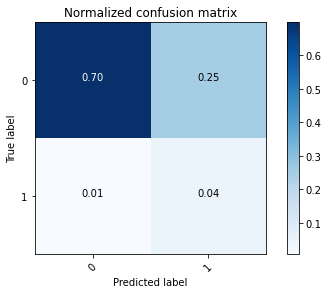

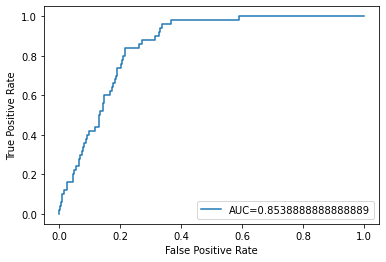

In [81]:
param_grid = {
    'n_estimators': [5, 10, 25, 50, 100, 500],
    'max_depth': range(3, 9, 2),
    'max_features': range(3, 11, 2)
}

randFor = tune_and_plot(X_train, y_train, X_test, y_test, RandomForestClassifier, param_grid)[0]

Vykreslení nejvíce vypovídajících příznaků díky atributu **feature_importances_**.

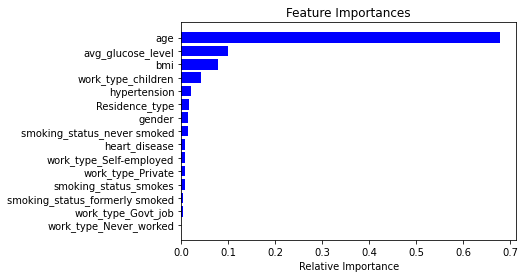

In [82]:
features = X.columns.values.tolist()
importances = randFor.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [83]:
data_after_model = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test})

y_test_1 = data_after_model['y_test'] == 1
y_test_0 = data_after_model['y_test'] == 0
y_pred_1 = data_after_model['y_pred'] == 1
y_pred_0 = data_after_model['y_pred'] == 0

false_negative = data_after_model.loc[y_test_1 & y_pred_0]
false_pozitive = data_after_model.loc[y_test_0 & y_pred_1]
true_pozitive = data_after_model.loc[y_test_1 & y_pred_1]

In [84]:
FN_id = false_negative.index
TP_id = true_pozitive.index
FP_id = false_pozitive.index
print(f'FP: {data.loc[FP_id].shape[0]}')
print(f'FN: {data.loc[FN_id].shape[0]}')
print(f'TP: {data.loc[TP_id].shape[0]}')

FP: 258
FN: 7
TP: 43


#### Logistic Regression/Logistická regrese

In [85]:
baseline = LogisticRegression(class_weight = 'balanced')
print('Baseline logistic regression accuracy: ', cross_val_score(baseline, X_train, y_train, n_jobs=-2).mean())

Baseline logistic regression accuracy:  0.8328067819518685


params: {'C': 0.01, 'fit_intercept': True, 'max_iter': 100, 'solver': 'newton-cg'} with accuracy 0.8349.
params: {'C': 0.01, 'fit_intercept': True, 'max_iter': 100, 'solver': 'lbfgs'} with accuracy 0.8349.
params: {'C': 0.01, 'fit_intercept': True, 'max_iter': 500, 'solver': 'newton-cg'} with accuracy 0.8349.
params: {'C': 0.01, 'fit_intercept': True, 'max_iter': 500, 'solver': 'lbfgs'} with accuracy 0.8349.
params: {'C': 0.01, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'newton-cg'} with accuracy 0.8349.
params: {'C': 0.01, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'lbfgs'} with accuracy 0.8349.
params: {'C': 0.01, 'fit_intercept': False, 'max_iter': 100, 'solver': 'newton-cg'} with accuracy 0.7984.
params: {'C': 0.01, 'fit_intercept': False, 'max_iter': 100, 'solver': 'lbfgs'} with accuracy 0.7984.
params: {'C': 0.01, 'fit_intercept': False, 'max_iter': 500, 'solver': 'newton-cg'} with accuracy 0.7984.
params: {'C': 0.01, 'fit_intercept': False, 'max_iter': 500, 'solv

params: {'C': 500, 'fit_intercept': False, 'max_iter': 500, 'solver': 'newton-cg'} with accuracy 0.8049.
params: {'C': 500, 'fit_intercept': False, 'max_iter': 500, 'solver': 'lbfgs'} with accuracy 0.8049.
params: {'C': 500, 'fit_intercept': False, 'max_iter': 1000, 'solver': 'newton-cg'} with accuracy 0.8049.
params: {'C': 500, 'fit_intercept': False, 'max_iter': 1000, 'solver': 'lbfgs'} with accuracy 0.8049.
Best params: {'solver': 'newton-cg', 'max_iter': 100, 'fit_intercept': True, 'C': 0.01} with accuracy 0.8349.
Test accuracy:  0.7025440313111546


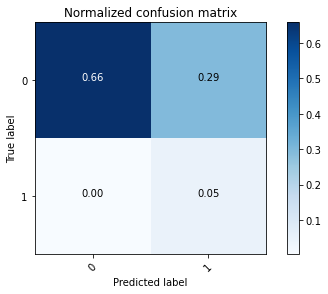

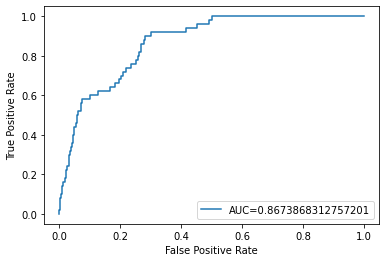

In [86]:
param_grid = {
    'C': [0.01, 0.1, 1.0, 10, 100, 200, 500],
    'fit_intercept': [True, False],
    'max_iter': [100, 500, 1000],
    'solver': ['newton-cg', 'lbfgs']
}

logReg = tune_and_plot(X_train, y_train, X_test, y_test, LogisticRegression, param_grid)[0]

Zde je vykreslení nejvíce vypovádajících atributů založeno na poskytnutých koeficientech logistické regrese.

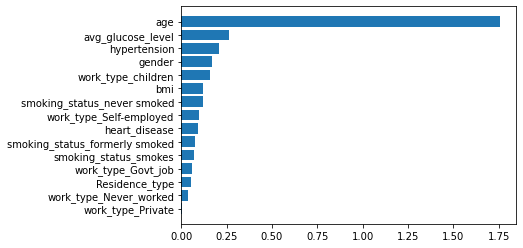

In [88]:
# show important features (careful, its based on coefficients which might skew the result 
# viz. https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)

f_importances(abs(logReg.coef_[0]), X.columns.values.tolist())

In [89]:
data_after_model = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test})

In [90]:
y_test_1 = data_after_model['y_test'] == 1
y_test_0 = data_after_model['y_test'] == 0
y_pred_1 = data_after_model['y_pred'] == 1
y_pred_0 = data_after_model['y_pred'] == 0

false_negative = data_after_model.loc[y_test_1 & y_pred_0]
false_pozitive = data_after_model.loc[y_test_0 & y_pred_1]
true_pozitive = data_after_model.loc[y_test_1 & y_pred_1]

In [91]:
FN_id = false_negative.index
TP_id = true_pozitive.index
FP_id = false_pozitive.index
print(f'FP: {data.loc[FP_id].shape[0]}')
print(f'FN: {data.loc[FN_id].shape[0]}')
print(f'TP: {data.loc[TP_id].shape[0]}')


FP: 300
FN: 4
TP: 46


## Závěr
Nejlepších výsledků dosáhl algoritmus logistické regrese. S těmito parametry model vynechal pouze 4 pacienty, kteří skutečně prodělali mrtvici. 

Naším cílem bylo co nejvíce snížit počet falešně negativních výsledků, což se logistické regresi podařilo. 